## Weather Classification
### Data Transformation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split

# Assemble pipeline(s)
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector
from imblearn.pipeline import Pipeline as imbPipeline

# Features engineering
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import OutlierTrimmer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import DropFeatures
from feature_engine.selection import DropConstantFeatures
from feature_engine.selection import DropCorrelatedFeatures
from feature_engine.selection import DropDuplicateFeatures
from feature_engine.transformation import YeoJohnsonTransformer

# Sampling
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours

In [3]:
# Dsplay pipelines
from sklearn import set_config
set_config(display="diagram")

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [5]:
# Weather Classification dataset
# It contains 21 columns including the target variable RainTomorrow (YES/NO).
df = pd.read_csv('../../../data/weather-classification-clean.csv')
df.sample(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,target
1731,2014-02-13,Region1,21.8,31.2,0.0,S,22.0,NW,SSE,11.0,...,57.0,39.0,1012.1,1009.1,5.0,5.0,24.9,29.9,No,0
20028,2011-09-21,Region9,7.3,24.6,0.0,NE,24.0,NNE,NNE,6.0,...,37.0,26.0,1018.5,1015.9,5.0,5.0,17.2,24.3,No,0
1966,2014-10-20,Region1,10.7,26.9,0.0,SE,31.0,SE,SSE,19.0,...,58.0,38.0,1024.8,1022.6,5.0,5.0,18.1,25.6,No,0
10622,2016-06-30,Region4,4.6,20.9,0.0,N,35.0,NW,N,15.0,...,68.0,33.0,1023.7,1018.2,5.0,3.0,14.8,19.3,No,0
18595,2015-09-24,Region8,14.6,20.0,11.4,WSW,54.0,W,W,26.0,...,62.0,72.0,1010.2,1008.3,3.0,2.0,18.3,17.8,Yes,1
5300,2016-03-19,Region2,11.7,24.8,0.8,SE,31.0,SSW,S,2.0,...,51.0,31.0,1011.0,1010.5,5.0,5.0,17.8,23.8,No,0
8522,2009-03-22,Region4,17.0,25.9,0.4,SSW,33.0,SW,SSE,13.0,...,78.0,63.0,1017.0,1015.1,7.0,5.0,20.6,25.0,No,1
3168,2009-09-04,Region2,9.5,24.9,7.6,WNW,44.0,NNE,NW,7.0,...,98.0,36.0,1014.7,1009.9,5.0,5.0,13.5,24.0,Yes,0
526,2010-06-11,Region1,7.2,13.2,0.0,W,28.0,WSW,WSW,6.0,...,82.0,66.0,1023.0,1019.7,7.0,7.0,9.2,12.8,No,0
20111,2011-12-17,Region9,14.8,25.3,0.0,ESE,22.0,S,NE,2.0,...,74.0,47.0,1018.5,1015.9,5.0,5.0,18.3,23.6,No,0


In [6]:
df.shape

(29679, 21)

In [172]:
# Selecting categorical and numeric features
sel_numeric = make_column_selector(dtype_include=['number'])
col_numerical = sel_numeric(df)

sel_categorical = make_column_selector(dtype_include=['object','category'])
col_categorical = sel_categorical(df)

sel_datetime = make_column_selector(dtype_include=['datetime','datetimetz','timedelta'])
col_datetime = sel_datetime(df)

## Feature Engineering

In [182]:
X = df_out.drop('target', axis=1)
y = df_out['target']
X.shape

(29679, 20)

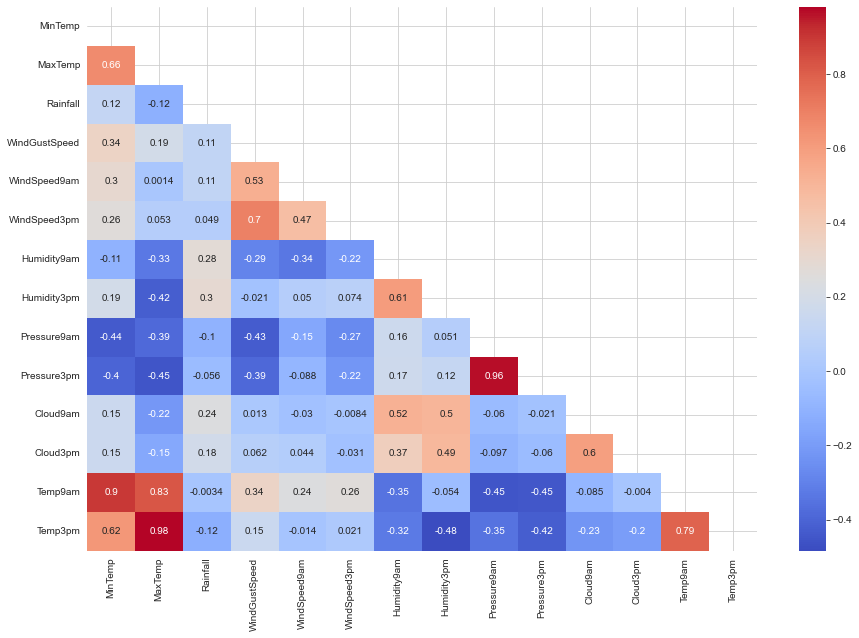

In [183]:
# Show features correlations
plt.figure(figsize=(15, 10))
sns.heatmap(data=X.corr(), cmap='coolwarm', mask=np.triu(X.corr()), annot=True)
plt.show()

In [184]:
ppl_fe = Pipeline([
    # Step 1: Features engineering
    ('conv_datetime', DatetimeFeatures(features_to_extract=['year','month','day_of_month'], variables=col_datetime, missing_values='ignore')),
    # ('drop_irrelevant', DropFeatures(['SubscriptionID','Address'])),
    ('drop_constant', DropConstantFeatures(tol=1, missing_values='ignore')),
    ('drop_duplicates', DropDuplicateFeatures()),
    ('drop_correlated', DropCorrelatedFeatures(method='pearson', threshold=0.8))
])

In [185]:
display(ppl_fe)

Pipeline(steps=[('conv_datetime',
                 DatetimeFeatures(features_to_extract=['year', 'month',
                                                       'day_of_month'],
                                  missing_values='ignore',
                                  variables=['Date'])),
                ('drop_constant',
                 DropConstantFeatures(missing_values='ignore')),
                ('drop_duplicates', DropDuplicateFeatures()),
                ('drop_correlated', DropCorrelatedFeatures())])

In [186]:
cols_before = X.columns
X_fe = ppl_fe.fit_transform(X)
X_fe.shape

(29679, 19)

In [187]:
# show dropped Correlated features
cols_after = X_fe.columns
dropped_features = cols_before.difference(cols_after)
print(f'Dropped features: {list(dropped_features)}')
added_features = cols_after.difference(cols_before)
print(f'Added features: {list(added_features)}')

Dropped features: ['Date', 'Pressure3pm', 'Temp3pm', 'Temp9am']
Added features: ['Date_day_of_month', 'Date_month', 'Date_year']


In [188]:
X_fe

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,Date_year,Date_month,Date_day_of_month
0,Region1,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,8.0,NaN,No,2008,12,1
1,Region1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,NaN,NaN,No,2008,12,2
2,Region1,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,NaN,2.0,No,2008,12,3
3,Region1,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,NaN,NaN,No,2008,12,4
4,Region1,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,Region12,8.6,18.6,0.2,SSW,56.0,NNW,S,13.0,28.0,69.0,67.0,1025.7,2.0,2.0,No,2017,6,21
36525,Region12,9.5,17.8,0.2,SW,35.0,NNW,SSE,9.0,9.0,74.0,70.0,1028.3,2.0,2.0,No,2017,6,22
36526,Region12,8.7,19.4,0.0,NNW,30.0,NW,NW,13.0,15.0,83.0,57.0,1020.8,6.0,6.0,No,2017,6,23
36527,Region12,9.4,19.9,0.0,SW,43.0,WNW,W,22.0,28.0,61.0,41.0,1017.3,5.0,2.0,No,2017,6,24


## Handling Missing Data

In [189]:
# Check Null Data
X_fe.isnull().sum()

Location                 0
MinTemp                  8
MaxTemp                 10
Rainfall                 0
WindGustDir              3
WindGustSpeed            0
WindDir9am            2351
WindDir3pm             233
WindSpeed9am             0
WindSpeed3pm             0
Humidity9am              0
Humidity3pm             25
Pressure9am           2979
Cloud9am             13967
Cloud3pm             13661
RainToday                0
Date_year                0
Date_month               0
Date_day_of_month        0
dtype: int64

In [190]:
# Selecting categorical and numeric features
col_numerical = sel_numeric(X_fe)
col_categorical = sel_categorical(X_fe)

ppl_imp = Pipeline([
    # Step 2: Impute and scale features
    ('num', MeanMedianImputer(imputation_method='median', variables=col_numerical)),
    ('cat', CategoricalImputer(imputation_method='frequent', variables=col_categorical))
])

In [191]:
display(ppl_imp)

Pipeline(steps=[('num',
                 MeanMedianImputer(variables=['MinTemp', 'MaxTemp', 'Rainfall',
                                              'WindGustSpeed', 'WindSpeed9am',
                                              'WindSpeed3pm', 'Humidity9am',
                                              'Humidity3pm', 'Pressure9am',
                                              'Cloud9am', 'Cloud3pm',
                                              'Date_year', 'Date_month',
                                              'Date_day_of_month'])),
                ('cat',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['Location', 'WindGustDir',
                                               'WindDir9am', 'WindDir3pm',
                                               'RainToday']))])

In [192]:
X_im = ppl_imp.fit_transform(X_fe)
X_im

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,Date_year,Date_month,Date_day_of_month
0,Region1,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,8.0,5.0,No,2008,12,1
1,Region1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,5.0,5.0,No,2008,12,2
2,Region1,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,5.0,2.0,No,2008,12,3
3,Region1,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,5.0,5.0,No,2008,12,4
4,Region1,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,Region12,8.6,18.6,0.2,SSW,56.0,NNW,S,13.0,28.0,69.0,67.0,1025.7,2.0,2.0,No,2017,6,21
36525,Region12,9.5,17.8,0.2,SW,35.0,NNW,SSE,9.0,9.0,74.0,70.0,1028.3,2.0,2.0,No,2017,6,22
36526,Region12,8.7,19.4,0.0,NNW,30.0,NW,NW,13.0,15.0,83.0,57.0,1020.8,6.0,6.0,No,2017,6,23
36527,Region12,9.4,19.9,0.0,SW,43.0,WNW,W,22.0,28.0,61.0,41.0,1017.3,5.0,2.0,No,2017,6,24


In [193]:
# Check Null Data
X_im.isnull().sum()

Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
WindGustDir          0
WindGustSpeed        0
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Cloud9am             0
Cloud3pm             0
RainToday            0
Date_year            0
Date_month           0
Date_day_of_month    0
dtype: int64

## Encoding Categorical Features

In [194]:
# Selecting categorical features
col_categorical = sel_categorical(X_im)

ppl_encode = Pipeline([
    # Step 3: Encode categorical features
    ('encode', OrdinalEncoder(encoding_method='arbitrary', variables=col_categorical))
])

In [195]:
X_en = ppl_encode.fit_transform(X_im)
X_en

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,Date_year,Date_month,Date_day_of_month
0,0.0,13.4,22.9,0.6,0,44.0,0,0,20.0,24.0,71.0,22.0,1007.7,8.0,5.0,0,2008,12,1
1,0.0,7.4,25.1,0.0,1,44.0,1,1,4.0,22.0,44.0,25.0,1010.6,5.0,5.0,0,2008,12,2
2,0.0,12.9,25.7,0.0,2,46.0,0,1,19.0,26.0,38.0,30.0,1007.6,5.0,2.0,0,2008,12,3
3,0.0,9.2,28.0,0.0,3,24.0,2,2,11.0,9.0,45.0,16.0,1017.6,5.0,5.0,0,2008,12,4
4,0.0,17.5,32.3,1.0,0,41.0,3,3,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,10.0,8.6,18.6,0.2,15,56.0,1,13,13.0,28.0,69.0,67.0,1025.7,2.0,2.0,0,2017,6,21
36525,10.0,9.5,17.8,0.2,6,35.0,1,5,9.0,9.0,74.0,70.0,1028.3,2.0,2.0,0,2017,6,22
36526,10.0,8.7,19.4,0.0,10,30.0,13,3,13.0,15.0,83.0,57.0,1020.8,6.0,6.0,0,2017,6,23
36527,10.0,9.4,19.9,0.0,6,43.0,14,4,22.0,28.0,61.0,41.0,1017.3,5.0,2.0,0,2017,6,24


In [196]:
X_en.isnull().sum()

Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
WindGustDir          0
WindGustSpeed        0
WindDir9am           0
WindDir3pm           0
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Cloud9am             0
Cloud3pm             0
RainToday            0
Date_year            0
Date_month           0
Date_day_of_month    0
dtype: int64

## Feature Scaling

In [197]:
ppl_scale = Pipeline([
    # Step 4: Features scaling
    ('scaler', YeoJohnsonTransformer())
])

In [198]:
X_sc = ppl_scale.fit_transform(X_en)
X_sc

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,RainToday,Date_year,Date_month,Date_day_of_month
0,0.000000,16.288579,4.382608,0.311366,0.000000,9.765618,0.000000,0.000000,8.490779,9.816123,211.276127,14.479290,2.124076e+08,14.404826,7.914360,-0.0,6.776762e+15,7.160850,0.900987
1,0.000000,8.580361,4.546723,-0.000000,0.868802,9.765618,0.880709,0.918254,2.681286,9.256347,113.422631,16.123924,2.142004e+08,7.907159,7.914360,-0.0,6.776762e+15,7.160850,1.680999
2,0.000000,15.630999,4.589538,-0.000000,1.583014,9.996438,0.000000,0.918254,8.202470,10.358216,93.810645,18.788555,2.123460e+08,7.907159,2.584589,-0.0,6.776762e+15,7.160850,2.391556
3,0.000000,10.846800,4.746797,-0.000000,2.212324,7.039364,1.618935,1.734727,5.632443,4.963377,116.775877,11.059719,2.185686e+08,7.907159,7.914360,-0.0,6.776762e+15,7.160850,3.054564
4,0.000000,21.764062,5.015613,0.386197,0.000000,9.408265,2.277592,2.491413,4.076554,8.676691,254.936058,20.348025,2.143244e+08,12.128887,14.421691,-0.0,6.776762e+15,7.160850,3.681987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36524,6.289355,10.086322,4.023020,0.154208,7.502824,11.074826,0.880709,8.711224,6.328379,10.884437,203.553958,36.655395,2.236960e+08,2.583285,2.584589,-0.0,6.930068e+15,4.143562,11.621057
36525,6.289355,11.228796,3.949210,0.154208,3.816319,8.647628,0.880709,3.890201,4.886777,4.963377,222.987026,38.007165,2.253585e+08,2.583285,2.584589,-0.0,6.930068e+15,4.143562,12.047537
36526,6.289355,10.212735,4.094439,-0.000000,5.593828,7.957057,7.198662,2.491413,6.328379,7.120982,259.000794,32.064558,2.205849e+08,9.959927,9.969966,-0.0,6.930068e+15,4.143562,12.468971
36527,6.289355,11.101337,4.137937,-0.000000,3.816319,9.648036,7.607479,3.206540,9.050951,10.884437,173.375734,24.387531,2.183802e+08,7.907159,2.584589,-0.0,6.930068e+15,4.143562,12.885624


## Balancing the dataset

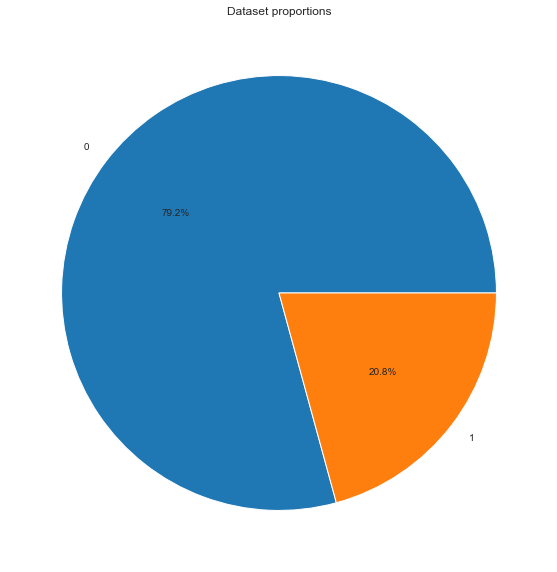

In [199]:
# Check if dataset is imbalanced
labels, counts = np.unique(y, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

We observe that data is imbalanced, we need to balance the data

In [200]:
cat_cols = []
for col in X_im.columns:
    if X_im[col].dtype == 'category':
        cat_cols.append(True)
    else:
        cat_cols.append(False)

In [201]:
# Sampling Pipeline
ppl_sample = imbPipeline([
    ('over-sampling', SMOTENC(categorical_features=cat_cols)),
    ('under-sampling', EditedNearestNeighbours())
])

In [202]:
X_sm, y_sm = ppl_sample.fit_resample(X_sc,y)

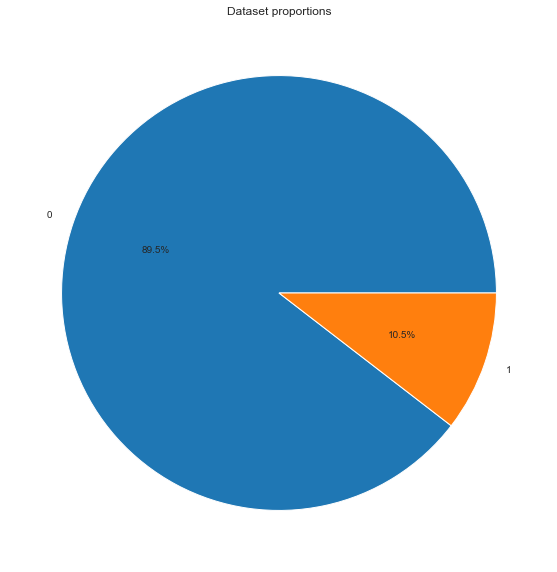

In [203]:
labels, counts = np.unique(y_sm, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, autopct='%1.1f%%', labels=labels)
plt.title('Dataset proportions')
plt.show()

## Save cleaned data

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2)
df_train_clean = pd.concat([X_train, y_train], axis=1)
df_test_clean = pd.concat([X_test, y_test], axis=1)
df_train_clean.to_csv('../../../data/weather-classification-train.csv', index=False)
df_test_clean.to_csv('../../../data/weather-classification-test.csv', index=False)